In [1]:
from qiskit import *
import numpy as np
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import AerSimulator

# Running on real hardware

IBM has made some of it's quantum computers publicly accessible via it's [cloud](https://quantum-computing.ibm.com/composer/docs/iqx/manage/systems/). This means YOU can run your own experiments on a REAL quantum computer!!! 

If you want to use one of IBM's real quantum devices, you first need to create an [IBM Quantum account](https://quantum-computing.ibm.com/).
Afterwards, you can find information about your account (such as your API token) [here](https://quantum-computing.ibm.com/account).

In [5]:
# connect to your IBMQ account
IBMProvider.save_account("740cf9a029345b5770ad72af52ca4d1c51eb8afe78c6d95e17ecffd2e72033a693cf8563418f2143cf5d9780f497e3100577f0a400d882f5d4314ca68ce9fc37",overwrite=True)
provider = IBMProvider()

Check out all the different [quantum devices](https://quantum-computing.ibm.com/services/resources?tab=systems) you have access to. Below I am setting the 5-qubit `ibmq_quito` device as the backend.

In [6]:
backend = provider.get_backend('ibmq_quito')

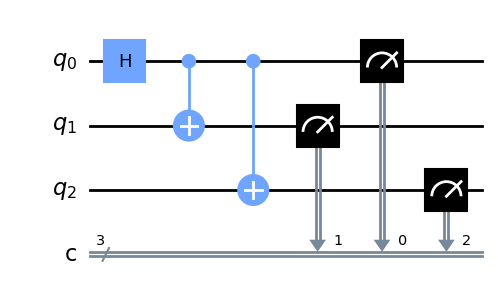

In [7]:
# GHZ state circuit from first notebook
circ = QuantumCircuit(3,3)
circ.h(0)
circ.cx(0, 1)
circ.cx(0, 2)
circ.measure(range(3), range(3))
circ.draw('mpl')

We can use the same `run` function as before to execute and measure the circuit.

However, running the next line will likely take a lot of time since all quantum devices are usually in use and you have to wait for your turn to run your job. You can [check](https://quantum-computing.ibm.com/services/resources?tab=systems) how many people are currently in the queue on any device. If you are doing research in quantum computation and have to run a lot of experiments on quantum devices, there is an option to get a researcher account which lets you reserve time on a quantum computer without waiting in the queue.

In [ ]:
#job = backend.run(circ, shots=1024)

For now, let's do something slightly different. Instead of running on a real quantum device we will use a "Fake" quantum device, i.e. a simulator that mimicks a real device. (For this, you do not need an IBMQ account.)

In [8]:
from qiskit.providers.fake_provider import FakeQuitoV2
backend = FakeQuitoV2() # use "fake" quito device as backend

In [9]:
job = backend.run(transpile(circ, backend), shots=1024)
result = job.result()
counts = result.get_counts(circ)
print(counts)

{'001': 13, '100': 23, '101': 30, '010': 33, '000': 475, '011': 88, '111': 335, '110': 27}


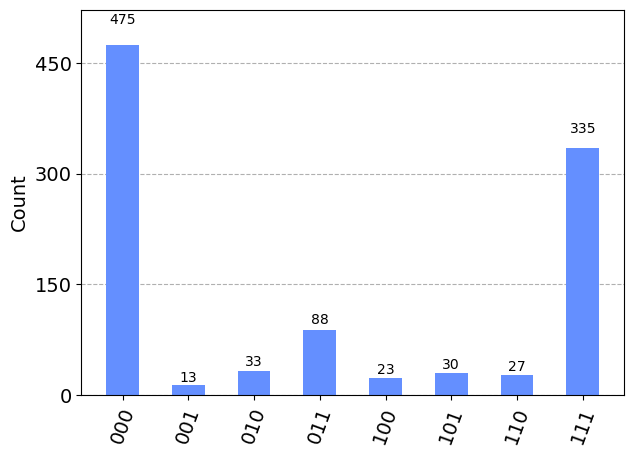

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

$\color{red}{\text{Exercise 1: Compare results to the one from previous notebook and explain discrepancy.}}$

Compare this result to the one we got at the end of the previous notebook. What would we expect? What happened here instead?

*Hint for exercise 1:* $\color{white}{\text{The reason for not just measuring the 000 and 111 bitstrings is noise and errors in the quantum computation. Can you think of different sources of noise that might alter the result of a quantum computation?}}$

The reason for not just measuring the 000 and 111 bitstrings is noise and errors in the quantum computation. Errors come from the state preparation and the measurement process and happen during the computation itself. The gates are also noisy and subject to coherent and incoherent errors. Coherent errors happen whenever the performed operation is slightly different from the gate that was supposed to be applied. For example, when performing a rotation, the rotation angle could be slightly off, leading to an over-or under-rotation. These errors can be kept small by properly calibrating the quantum devices. Incoherent errors are noise due to randomness and interactions with an environment. A qubit can never be shielded 100% from its surroundings and will inevitabely get entangled with the environment. This is the process of decoherence. All of these effects combined lead to an imperfect GHZ state in the example above.

## Transpilation 

### Basis gates

When writing a quantum circuit you are free to use any quantum gate (unitary operator) that you like, along with a collection of non-gate operations such as qubit measurements and reset operations. However, when running a circuit on a real quantum device one no longer has this flexibility. Due to limitations in, for example, the physical interactions between qubits, difficulty in implementing multi-qubit gates, control electronics etc, a quantum computing device can only natively support a handful of quantum gates and non-gate operations. In the present case of [IBM Q devices](https://quantum-computing.ibm.com/services/resources?tab=systems), the native gate set can be found by querying the devices themselves, and looking for the corresponding attribute in their configuration:

In [11]:
provider.get_backend('ibmq_quito').configuration().basis_gates

['cx', 'id', 'rz', 'sx', 'x']

Every quantum circuit run on an IBM Q device must be expressed using only these basis gates.

Let's take the following circuit as an example:

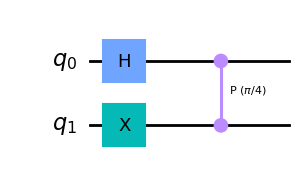

In [12]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.cp(np.pi/4, 0, 1)
qc.draw('mpl')

We have H, X, and controlled-P gates, all of which are not in our devices basis gate set, and must be expanded. This expansion is taken care of for us in the `run` function. However, we can decompose the circuit to show what it would look like in the native gate set of the IBM Quantum devices:

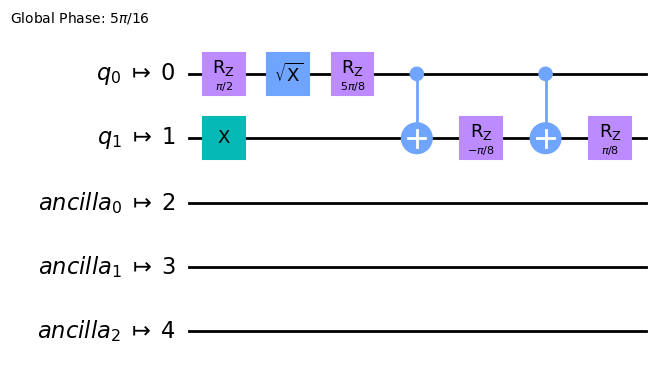

In [13]:
qc_basis = transpile(qc, backend)
qc_basis.draw('mpl')

A few things to highlight. First, the circuit has gotten longer with respect to the initial one. Second, although we had a single controlled gate, the fact that it was not in the basis set means that, when expanded, it requires more than a single cx gate to implement. All said, unrolling to the basis set of gates leads to an increase in the depth of a quantum circuit and the number of gates. The deeper a circuit, the more noise and errors will our quantum states be subject to. Keep this in mind when designing circuits that are run on real quantum devices.

### Hardware topology & layout

At this point, please check out the [IBM Q Systems](https://quantum-computing.ibm.com/services/resources?tab=systems) one more time. Take a look at a few different devices and especially the corresponding device topology displayed under "Calibration data". You should see that the physical qubits of the quantum devices are not all-to-all connected, e.g., qubit 1 might not be adjacent to qubit 4 and therefore you cannot apply a two-qubit gate between them.

In order to implement a CNOT gate between qubits in a quantum circuit that are not directly connected on a quantum device one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map. Each SWAP gate is decomposed into three CNOT gates on the IBM Quantum devices, and represents an expensive and noisy operation to perform.

For example, consider the following 5-qubit GHZ circuit that requires CNOT gates between qubit 0 and all other qubits.

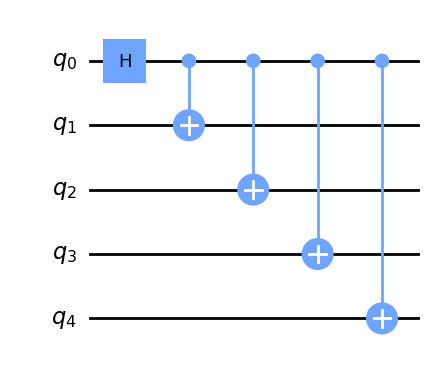

In [14]:
qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,range(1,5))
qc.draw(output='mpl')

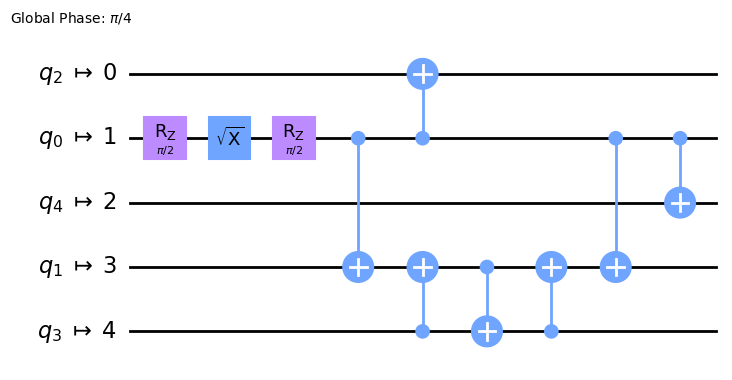

In [15]:
qc_hardware = transpile(qc, backend)
qc_hardware.draw(output='mpl')

After mapping this circuit to the hardware topology, we find about 3 times as many CNOT gates. Note that CNOT gates are the most noisy ones and should be avoided if possible. Try to adapt your circuit always to the hardware topology as much as possible.

Additionally, you might find that the qubit ordering is now different than to what we had defined before. Qiskit is trying to map the "virtual" qubits that we specified to actual physical qubits of the device in the most optimal way. The choice of mapping depends on the properties of the circuit, the particular device you are targeting, and the optimization level that is chosen.

You can also specify the mapping yourself by passing an `initial_layout` to the `transpile` function.

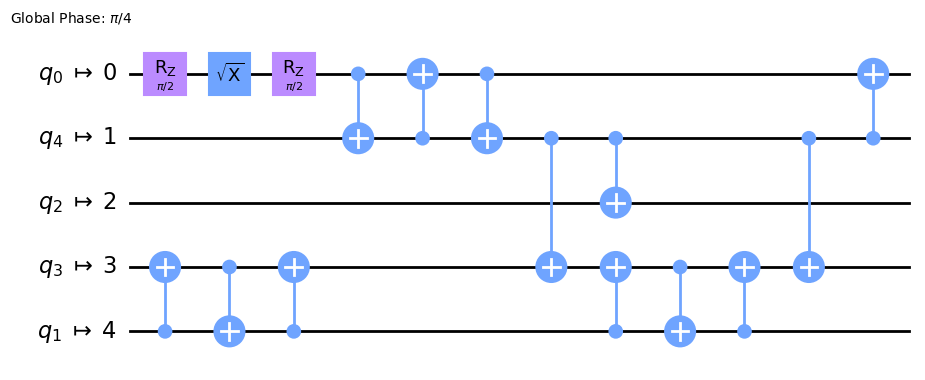

In [16]:
qc_hardware = transpile(qc, backend, initial_layout=[0,4,2,3,1])
qc_hardware.draw(output='mpl')

$\color{red}{\text{Exercise 2: Can you think of another qubit ordering that would reduce the number of SWAP/CNOT gates for the Quito device?}}$

Or alternatively, can you think of another, logically equivalent circuit that would also prepare the GHZ state, but involves CNOT gates applied only to adjacent qubits?

Try it out

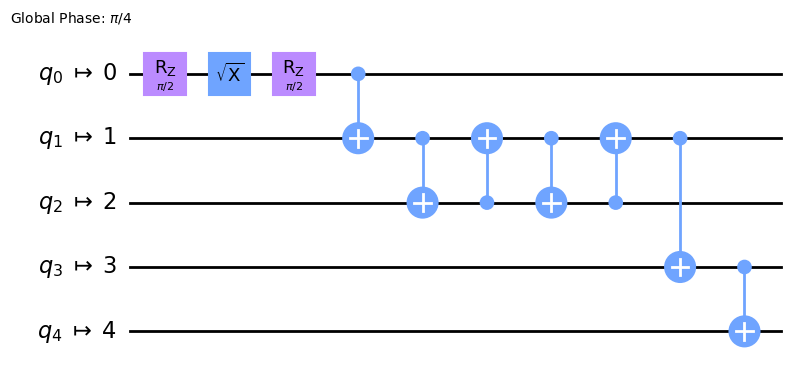

In [17]:
qc = QuantumCircuit(5)

#Your code goes here
# qc.h(0)
# qc.cx(0,range(1,5))
# qc_hardware = transpile(qc, backend, initial_layout=[1,0,2,3,4])

# or
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.cx(3,4)
qc_hardware = transpile(qc, backend, initial_layout=[0,1,2,3,4])

qc_hardware.draw(output='mpl')

*Hint for exercise 2:* $\color{white}{\text{What happens for example if qubit 1 (and not 0) is the control qubit?}}$

Note that the process of mapping a circuit to the device layout/topology is not deterministic but involves a stochastic optimization procedure. Therefore, the final circuits might look different every single time you run `transpile()`.

### Transpilation

In all the examples above, we have always used qiskit's `transpile` function.

In general, [transpilation](https://qiskit.org/documentation/apidoc/transpiler.html) is the process of rewriting a given input circuit to match the topology of a specific quantum device, and/or to optimize the circuit for execution on present day noisy quantum systems.

Most circuits must undergo a series of transformations that make them compatible with a given target device, and optimize them to reduce the effects of noise on the resulting outcomes. Rewriting quantum circuits to match hardware constraints and optimizing for performance can be far from trivial. The flow of logic in the rewriting tool chain need not be linear, and can often have iterative sub-loops, conditional branches, and other complex behaviors. The details are not important for you at this stage, just be aware that transpilation is an important but potentially very complex process.

![title](transpiling_core_steps.png)


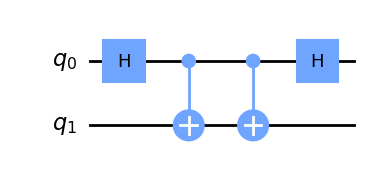

In [18]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.cx(0,1)
qc.h(0)
qc.draw(output='mpl')

$\color{red}{\text{Exercise 3: Transpile and visualize the circuit above.}}$

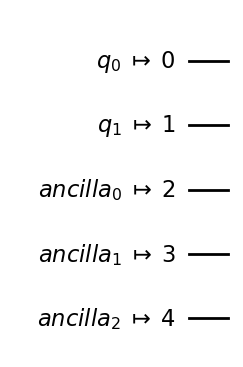

In [19]:
#Your code goes here

qc_transpiled = transpile(qc, backend)
qc_transpiled.draw(output='mpl')

What happened here?

*Hint for exercise 3:* $\color{white}{\text{What does the circuit above do? What are the inverses of the CNOT and H gates? Transpilation also optimizes the circuit and reduces the number of gates if possible.}}$

The CNOT is its own inverse (same for the Hadamard gate). Hence, the circuit above is just the identity. When transpiling, qiskit tries to reduce the number of circuit operations as much as possible and gets rid of all gates that would reduce to the identity.

If you don't want the transpiler to optimize over some gates, you can add "Barriers". A barrier prevents merging different parts of the circuit during the optimization process. For an ideal quantum computer, this does not change the results.


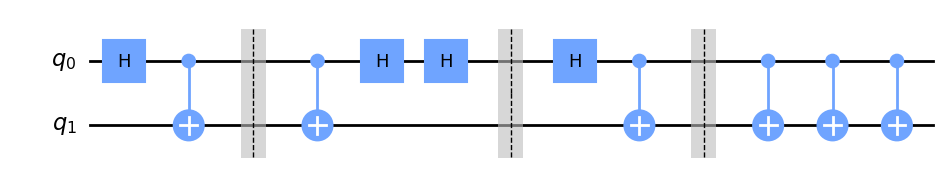

In [17]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.h(0)
qc.barrier()
qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.cx(0,1)
qc.cx(0,1)
qc.cx(0,1)
qc.draw(output='mpl')

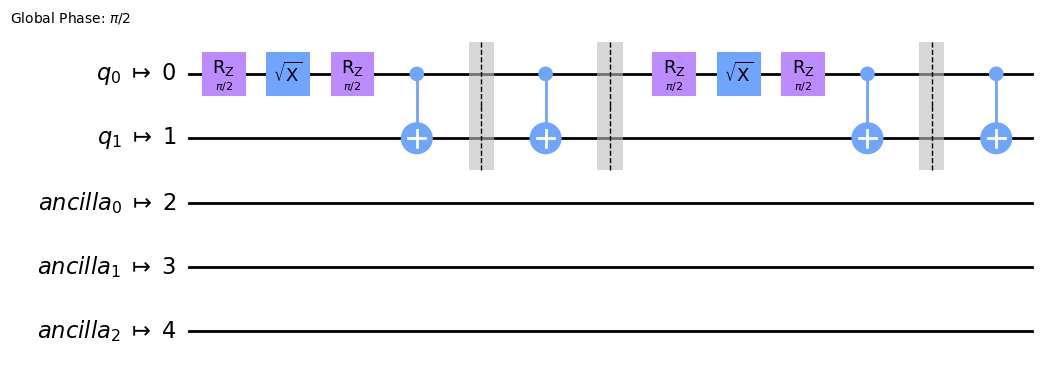

In [18]:
qc_transpiled = transpile(qc, backend)
qc_transpiled.draw(output='mpl')

The circuit could be simplified much more, but the barriers prevent any further optimization.

$\color{red}{\text{Optional Exercise 4: Define a random circuit, transpile it, and visualize the output counts.}}$

Use qiskit's [random_circuit](https://qiskit.org/documentation/stubs/qiskit.circuit.random.random_circuit.html) implementation or be creative. You can also try to run it on a real device, but it might take a little while.

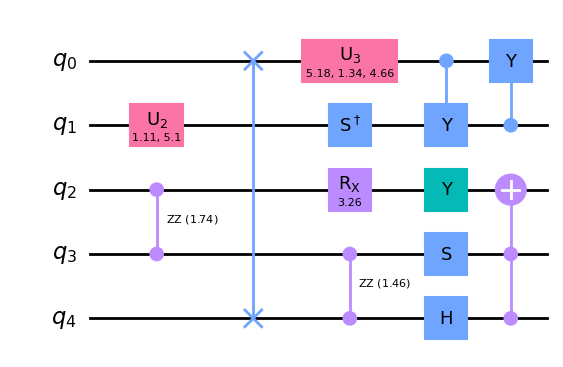

In [19]:
from qiskit.circuit.random import random_circuit

#Your code goes here

qc = random_circuit(5, depth=4, seed=123)
qc.draw(output='mpl')

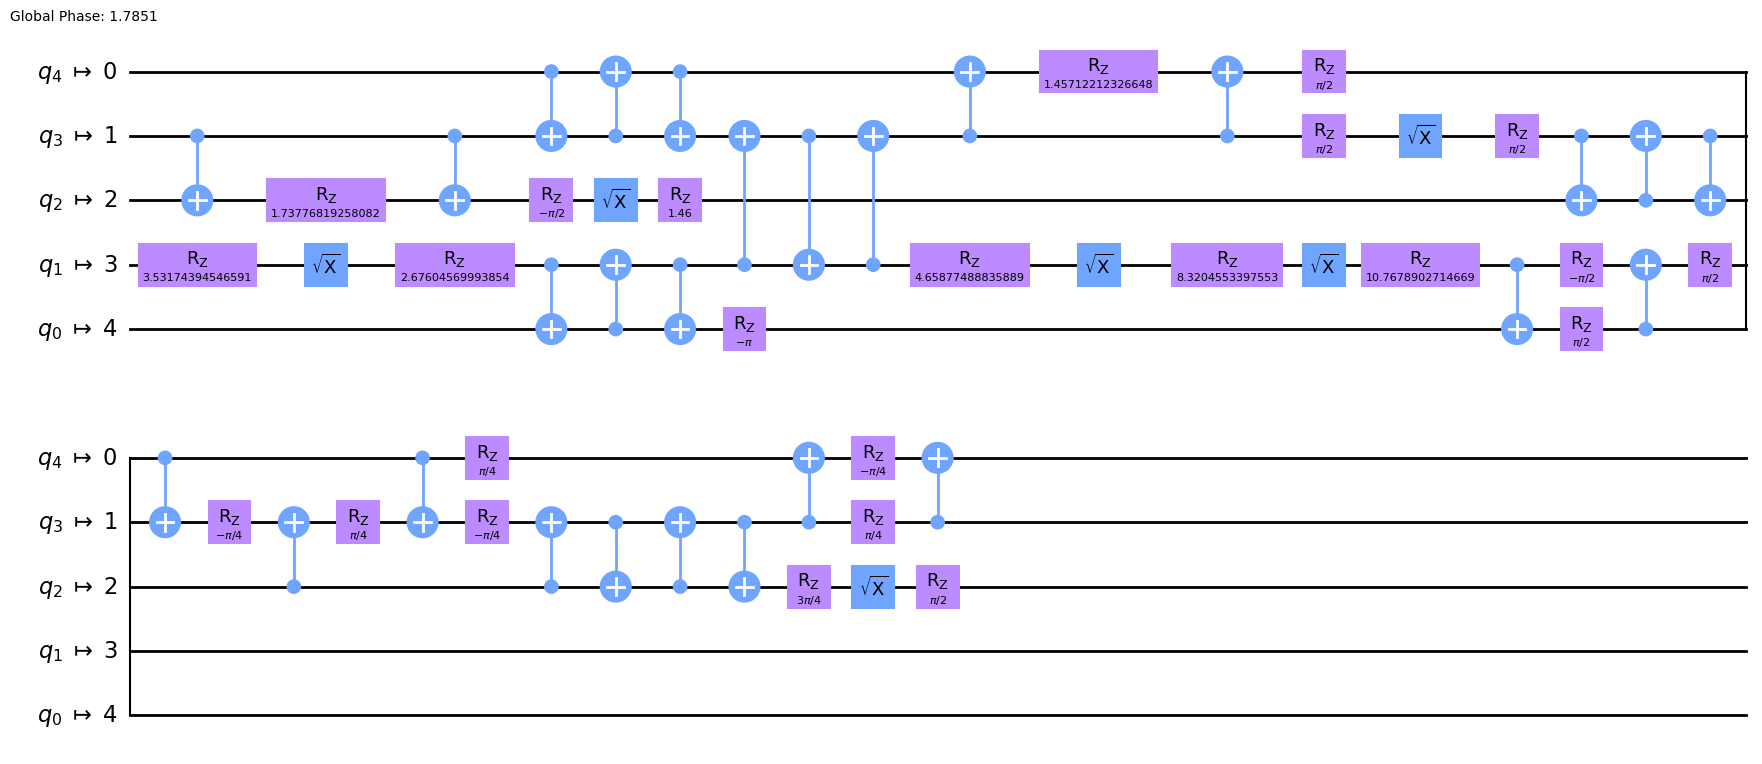

In [20]:
qc_transpiled = transpile(qc, backend)
qc_transpiled.draw(output='mpl')

These notebooks are comprised of text and code taken from Qiskit's [documentation](https://qiskit.org/documentation/), [tutorials](https://qiskit.org/documentation/tutorials.html#quantum-circuits), [textbook](https://qiskit.org/textbook/preface.html), and previous challenges facilitated by Qiskit.